In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model

In [6]:
import json
import csv
import re

from random import shuffle, choice
from copy import deepcopy

from collections import defaultdict
from collections import Counter

import shutil
import requests

import matplotlib.pyplot as plt
from PIL import Image

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
%config Completer.use_jedi = False

### Step 1: look at the data

In [8]:
with open("product_data.json", "r") as content:
    data = json.load(content)

In [9]:
def format_(num):
    if num < 10:
        return '000' + str(num)
    elif num < 100:
        return '00' + str(num)
    else:
        return '0' + str(num)

In [12]:
for i in range(1000):
    url = data[i]['image_url']
    fname = format_(i)
    path = 'images/{}.jpg'.format(fname)
    
    r = requests.get(url, stream=True, headers={'User-agent': 'Mozilla/5.0'})

    if r.status_code == 200:
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)  

In [15]:
def show_images(data):
    n = len(data)
    rows = n // 2
    columns = 2
    count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(20, 5 * rows))

    for i in range(rows):
        for j in range(columns):        
            if count < rows * columns:
                fname = 'images/' + format_(data[count][0]) + '.jpg'
                img = Image.open(fname)
                description = data[count][1][:75]
                axes[i, j].imshow(img)
                axes[i, j].title.set_text(str(data[count][0]) + ' ' + description)
                count += 1

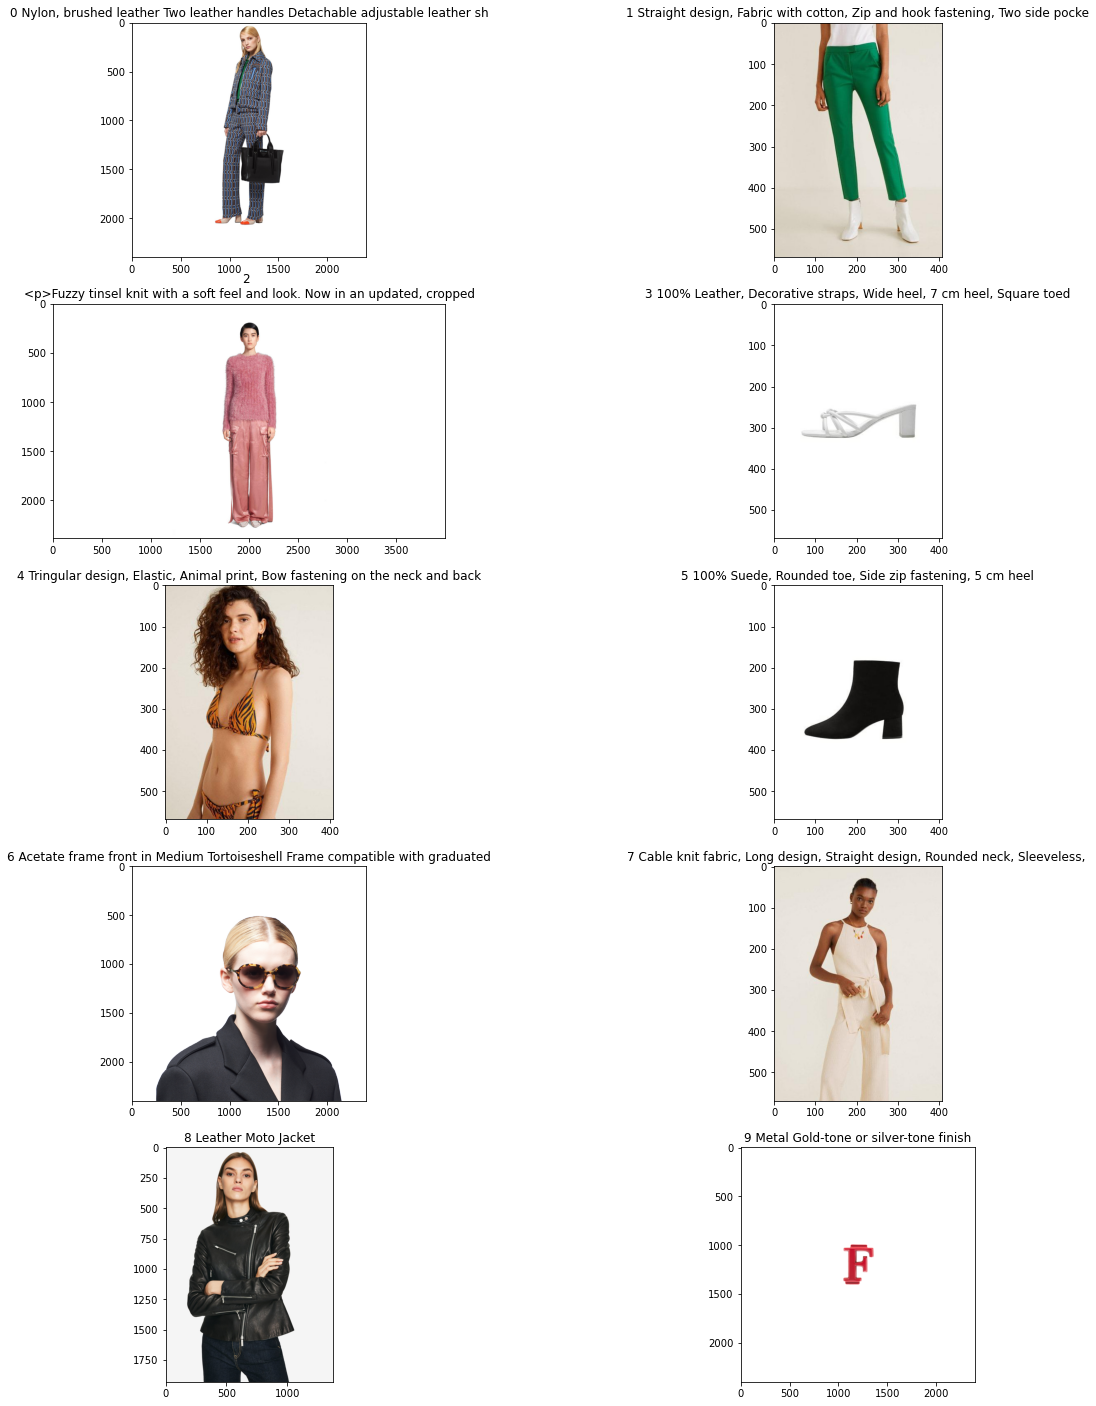

In [14]:
sample = [(i, item['description']) for (i, item) in enumerate(data[:10])]
show_images(sample)

At first glance it seems like training a computer vision-based model should work to classify these items. But if we look at the images, we see many examples like the first one above which contain multiple categories, and the description is required to disambiguate. And categories like jumpsuit might be hard to identify. Still, such a model could get us part of the way there.

Turning to the descriptions, they seem useful but we need to find a way to map this free text to categories. Upon inspection, there are keywords that can help in this respect. For example, {"strap", "leather", "handles"} often correspond to bag, {"pockets", "zipper", "belt loops"} correspond to pants, and so on. But we have to be careful about false positives.

As a starting point, I hand-labeled of about 100 examples of each class from a combination of looking at random images and manually searching for specific keywords.

In [10]:
manually_labeled_data = {
    0: [2, 17, 27, 28, 30, 40, 45, 48, 175, 807, 825], # tops
    1: [23, 37, 38, 41, 43, 46, 49, 801, 821, 826, 895], # dresses
    2: [1, 11, 13, 19, 26, 304, 567, 816, 818, 836, 842, 860, 862, 874], # pants
    3: [495, 571, 601, 608, 620, 657, 811, 823, 940], # skirts,
    4: [4, 131, 629, 630, 736, 800, 810, 848], # lingerie
    5: [8, 21, 200, 300, 333, 467, 568, 829, 838, 875, 924, 947], # outerwear
    6: [7, 47, 63, 382, 481, 523, 554, 639, 650, 735, 774, 851], # jumpsuit
    7: [9, 14, 34, 42, 299, 805, 819, 868, 906, 948, 972, 974], # jewelry
    8: [0, 15, 20, 22, 24, 32, 36, 39, 813, 815, 824, 884, 938], # bags
    9: [3, 5, 16, 25, 111, 121, 214, 886, 912, 925, 926, 952, 973], # shoes
    10: [6, 74, 142, 156, 283, 410, 846, 872, 899, 958, 960, 985], # glasses (most of other)
}

### Step 2: Create keywords for each category

Using this dataset, I hacked together a set of keywords that identify each category and selected those with high precision.

In [11]:
def get_parsed_descriptions(data):
    results = []
    for i in range(1000):
        description = data[i]['description'].lower()
        description = re.sub('[^a-zA-Z-]+', ' ', description)
        results.append(description)
    return results

parsed_descriptions = get_parsed_descriptions(data)

In [9]:
def get_category_frequencies(items, descriptions): 
    '''
    Items are the item ids corresponding to the category.
    Descriptions is the list of parsed descriptions for each item.
    '''
    stops = set(stopwords.words('english'))
    grams = defaultdict(int)
    
    for item in items:
        description = descriptions[item]
        words = [w for w in description.split() if w not in stops]
        bigrams = set(zip(words, words[1:]))
        
        for word in set(words):
            grams[(word)] += 1
        for pair in bigrams:
            grams[pair] += 1
    
    return grams

In [10]:
def identify_keywords(manually_labeled_data, descriptions, n):
    '''
    A hacky way to identify keywords for given categories, given some labeled data.
    
    For each category, we get the frequencies of uni/bigrams that appear.
    Then we filter down to those that appear >5 times in the overall corpus.
    Finally, we select for each category the ngrams that are common in that 
    category but not in any of the others.
    '''
    overall_frequencies = get_category_frequencies(range(1000), descriptions)
    
    category_frequencies_map = {}
    for i in range(11):
        category_items = manually_labeled_data[i]
        cat_freqs = get_category_frequencies(category_items, descriptions)
        category_frequencies_map[i] = {k: v for (k, v) in cat_freqs.items() if 
                                       overall_frequencies[k] >= 5}
    
    keywords_map = {}
    for i in range(11):
        this_cat_freqs = category_frequencies_map[i]
        other_cats = [category_frequencies_map[c] for c in range(11) if c != i]
        other_cats_freqs = sum((Counter(x) for x in other_cats), Counter())
        
        scores = {}
        for k, v in this_cat_freqs.items():
            scores[k] = v / (other_cats_freqs.get(k, 0) + 1) # handle zero case
            top_grams = sorted(scores, key=lambda k: scores[k], reverse=True)[:n]
     
        keywords_map[i] = top_grams
    
    return keywords_map

In [11]:
keywords = identify_keywords(manually_labeled_data, parsed_descriptions, 10)

print(keywords[4])

['sweat-wicking', 'america', 'bra', 'quick', 'supplex', 'lycra', 'four-way', 'natural', 'oh', 'women']


In [12]:
keyword_map = {
    0: ["tank", "shirt", "crewneck", "short sleeve", "knit", "rayon"],
    1: ["flared design", "dress", "halter"],
    2: ["side pockets", "one button", "belt loops"],
    3: ["skirt"],
    4: ["lycra", "sports bra", "supplex", "elastic"],
    5: ["hood", "lapel-collar", "jacket"],
    6: ["straight design", "long design"],
    7: ["metallic", "cuff", "tone finish"],
    8: ["nylon lining", "leather handle", "shoulder strap", "leather shoulder"], 
    9: ["toe", "heel", "sole"],
    10: ["frame", "lens"]
}

In [13]:
def check_word(word):
    items = []
    for i, description in enumerate(parsed_descriptions):
        if word in description:
            items.append((i, description))
    show_images(items)

For example, "crewneck" reliably identifies a top.

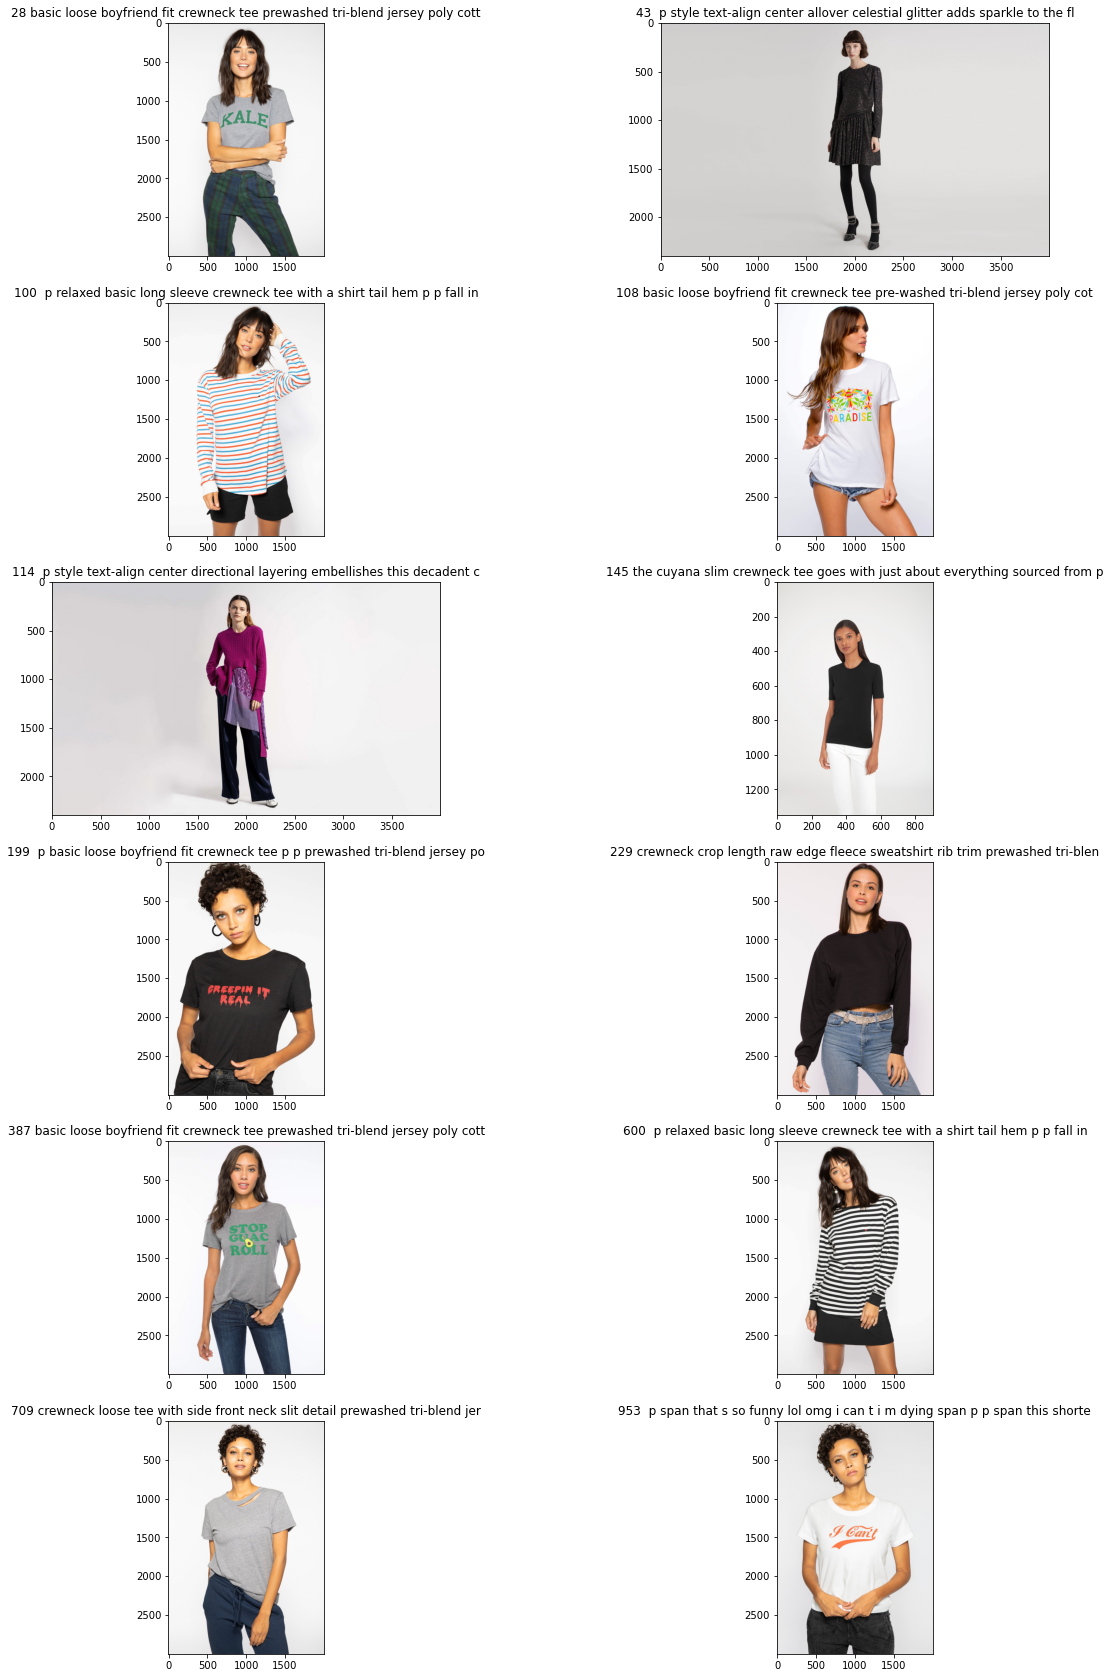

In [14]:
check_word('crewneck')

This covers about half the dataset, with a decent spread between categories.

In [19]:
coverage = 0
cat_to_items = defaultdict(list)

keywords = set()
for c, words in keyword_map.items():
    for word in words:
        keywords.add(word)
        
for i, item in enumerate(data):
    description = item['description'].lower()
    found = False
    for cat, words in keyword_map.items():
        for word in words:
            if word in description:
                cat_to_items[cat].append(i)
                found = True
    if found == True:
        coverage += 1

print(coverage)
print([len(cat_to_items[i]) for i in range(11)])

582
[62, 82, 113, 19, 121, 29, 118, 82, 179, 101, 66]


This is pretty good. But we probably want to handle cases where the text is not that descriptive. We still haven't used the raw image data, so let's train an image classification model using the above labeled dataset.

### Step 3: train an image classification model

First we'll split this data randomly into train/val/test sets, and then we'll train a CNN model. If I had more time, I'd use some data augmentation techniques to get more training data or try transfer learning, but this performs surprisingly well as is.

In [17]:
train = {}; val = {}; test = {}

for cat, items in cat_to_items.items():
    shuffle(items)
    n = len(items)
    train_cutoff = int(n * .6); val_cutoff = int(n * .8)
    
    train[cat] = items[:train_cutoff]
    val[cat] = items[train_cutoff:val_cutoff]
    test[cat] = items[-val_cutoff:]
    
for cat, items in train.items():
    for item in items:
        path = 'data/train/{0}/{1}.jpg'.format(cat, item)
        url = data[item]['image_url']
    
        r = requests.get(url, stream=True, headers={'User-agent': 'Mozilla/5.0'})
        if r.status_code == 200:
            with open(path, 'wb') as f:
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)

for cat, items in val.items():
    for item in items:
        path = 'data/val/{0}/{1}.jpg'.format(cat, item)
        url = data[item]['image_url']
    
        r = requests.get(url, stream=True, headers={'User-agent': 'Mozilla/5.0'})
        if r.status_code == 200:
            with open(path, 'wb') as f:
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)

for cat, items in test.items():
    for item in items:
        path = 'data/test/{0}/{1}.jpg'.format(cat, item)
        url = data[item]['image_url']
    
        r = requests.get(url, stream=True, headers={'User-agent': 'Mozilla/5.0'})
        if r.status_code == 200:
            with open(path, 'wb') as f:
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f) 

In [15]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train/",
    label_mode='categorical')

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val/",
    label_mode='categorical')

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test/",
    label_mode='categorical')

Found 889 files belonging to 11 classes.
Found 148 files belonging to 11 classes.
Found 507 files belonging to 11 classes.


In [16]:
# Let's try a classic convolutional model (AlexNet).
# We could also try transfer learning using a pretrained model.

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(11,activation='softmax')  
])

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-10-19 22:14:05.828 ip-172-31-7-159:7502 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-10-19 22:14:05.855 ip-172-31-7-159:7502 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint("saved_models/alexnet_save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

In [ ]:
# skip the cell to avoid all the training output
model = load_model("saved_models/alexnet_save_at_1.h5")

model.fit(
    train_dataset, epochs=3, callbacks=callbacks, validation_data=val_dataset
)

In [20]:
best_model = load_model("saved_models/best_model.h5")

In [98]:
best_model.evaluate(test_dataset)

16/16 [==============================] - 17s 595ms/step - loss: 1.3802 - categorical_accuracy: 0.5641


[1.3802061080932617, 0.5641025900840759]

For the finished product, I will combine the keyword matching logic with the results of our model. That is, first we parse the description and determine if it contains any of our keywords. If so, we output the relevant category. Otherwise, run the image through our model and output the prediction with the highest score.

In [23]:
result_map = {
    0: "Top",
    1: "Dress",
    2: "Pant",
    3: "Skirt",
    4: "Lingerie",
    5: "Outerwear",
    6: "Jumpsuit",
    7: "Jewelry",
    8: "Bag",
    9: "Shoes",
    10: "Other"
}

In [21]:
def get_classifier_prediction(i):
    fname = format_(i)
    img = load_img(
        'images/{}.jpg'.format(fname), target_size=(256, 256)
    )
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = best_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    return result_map[np.argmax(score)]

In [28]:
output = deepcopy(data)

manually_labeled_set = set()
for cat, items in manually_labeled_data.items():
    for item in items:
        manually_labeled_set.add(item)

for i, description in enumerate(parsed_descriptions):
    if i in manually_labeled_set:
        for cat, items in manually_labeled_data.items():
            if i in items:
                category = result_map[cat]
                break

    else:
        matches = []
        for cat, terms in keyword_map.items():
            if any([term in description for term in terms]):
                matches.append(cat)

        if matches:
            category = result_map[choice(matches)]
        else:
            category = get_classifier_prediction(i)
    
    output[i]['category'] = category

In [30]:
with open("output.json", "w") as f:
    json.dump(output, f)